# Home Credit Scorecard Model
**Name** : Azarya Yehezkiel Pinondang Sipahutar <br><br>
**Project Goal** : To develop a scorecard model to predict the probability of a customer to default on a loan. <br><br>
**Project Objective** : 

Pelanggan yang mampu melakukan pelunasan tidak ditolak ketika melakukan pengajuan pinjaman, dan pinjaman dapat diberikan dengan principal, maturity, dan repayment calendar yang akan memotivasi pelanggan untuk sukses

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [2]:
# original data
app_train = pd.read_csv('./data/application_train.csv')
app_test = pd.read_csv('./data/application_test.csv')
bureau = pd.read_csv('./data/bureau.csv')
bureau_balance = pd.read_csv('./data/bureau_balance.csv')
ccb = pd.read_csv('./data/credit_card_balance.csv')
ip = pd.read_csv('./data/installments_payments.csv')
pb = pd.read_csv('./data/POS_CASH_balance.csv')
pa = pd.read_csv('./data/previous_application.csv')


# sample data
train_sample = app_train.sample(frac=0.05)
test_sample = app_test.sample(frac=0.05)
bureau_sample = bureau.sample(frac=0.05)
bb_sample = bureau_balance.sample(frac=0.05)    
ccb_sample = ccb.sample(frac=0.05)
ip_sample = ip.sample(frac=0.05)
pb_sample = pb.sample(frac=0.05)
pa_sample = pa.sample(frac=0.05)

In [3]:
pd.set_option('display.max_columns', None)

## Data Cleaning and Processing

In [4]:
# function to drop columns with missing values
def dropna(df, threshold=0.45):
    '''
    Drop columns from a DataFrame where the proprortion of missing values is greater than specified threshold.

    Parameters:
    df: The DataFrame to process
    threshold: The threshold proportion of missing vales. Columns with a proportion of missing values greater than this will be dropped.

    Returns:
    Pandas.DataFrame: The processed DataFrame. 
    '''
    for column in df.columns:
        missing_proportion = df[column].isnull().sum() / len(df)
        if missing_proportion > threshold:
            df = df.drop(column, axis=1)
    return df

# function to plot missing value percentage
def plot_missing_percentage(df):
    """
    Plot the percentage of missing values for each column in a DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame to process.
    """
    # Calculate the percentage of missing values
    missing = df.isnull().sum() * 100 / len(df)

    # Create a DataFrame with the results
    percentage_missing = pd.DataFrame({'column': df.columns, 'missing_percentage %': missing.values})
    percentage_missing['missing_percentage %'] = percentage_missing['missing_percentage %'].round(2)
    percentage_missing = percentage_missing.sort_values('missing_percentage %', ascending=False)
    percentage_missing = percentage_missing.reset_index()
    percentage_missing = percentage_missing.drop('index', axis=1)

    # Plot the results
    plt.figure(figsize=(15, 20))
    ax = sns.barplot(x='missing_percentage %', y='column', data=percentage_missing, color='#E1341E')
    for p in ax.patches:
        ax.annotate("%.2f" % p.get_width() + '%', xy=(p.get_width(), p.get_y()+p.get_height()/2),
                    xytext=(8, 0), textcoords='offset points', ha="left", va="center", fontsize=10)
    plt.title('Missing values Percentage for Each Column', fontsize=17, fontweight='bold')
    plt.ylabel('Kolom', fontsize=12)
    plt.xlabel('missing_percentage %', fontsize=12)
    plt.tight_layout()
    plt.show()

In [12]:
# merge the data
bureau_merge = pd.merge(bureau_sample, bb_sample, on='SK_ID_BUREAU', how='left', suffixes=('_bureau', '_bb'))

train_bureau = pd.merge(train_sample, bureau_merge, on='SK_ID_CURR', how='left', suffixes=('', '_bureau_bb'))
test_bureau = pd.merge(test_sample, bureau_merge, on='SK_ID_CURR', how='left', suffixes=('', '_bureau_bb'))

# merge previous applications
pa_pos = pd.merge(pa_sample, pb_sample, on='SK_ID_PREV', how='left', suffixes=('_pa', '_pb'))
pa_cb = pd.merge(pa_pos, ccb_sample, on='SK_ID_PREV', how='left', suffixes=('_pa_pb', '_ccb'))
pa_full = pd.merge(pa_cb, ip_sample, on='SK_ID_PREV', how='left', suffixes=('_pa_pb_ccb', '_ip'))
pa_full.rename(columns={'SK_ID_CURR_pa': 'SK_ID_CURR'}, inplace=True)

train_full = pd.merge(train_bureau, pa_full, on='SK_ID_CURR', how='left')
test_full = pd.merge(test_bureau, pa_full, on='SK_ID_CURR', how='left')

# Drop the right dataframe's columns
train_full = train_full[train_full.columns.drop(list(train_full.filter(regex='_bb|_bureau_bb|_pb|_pa_pb|_ccb|_pa_pb_ccb|_ip|_pa_full')))]
test_full = test_full[test_full.columns.drop(list(test_full.filter(regex='_bb|_bureau_bb|_pb|_pa_pb|_ccb|_pa_pb_ccb|_ip|_pa_full')))]

print(train_full.shape)
print(test_full.shape)

(19360, 201)
(3736, 200)


In [13]:
# Create a list of dataframes to clean
df2clean = [train_full, test_full]

# Loop through the list and clean each dataframe by dropping NA values
for i, df in enumerate(df2clean):
    df2clean[i] = dropna(df)

# Unpack the cleaned dataframes back into their original variables
train_full, test_full = df2clean

# Get a list of column names from the train dataframe, excluding the 'TARGET' column
traincol = train_full.drop('TARGET', axis=1).columns

# Restrict the columns in the test dataframe to match those in the train dataframe
test_full = test_full[traincol]

# Print the shape of the dataframes to check the number of rows and columns
print(train_full.shape)
print(test_full.shape)

(19360, 73)
(3736, 72)


train data: 
(5745, 104)


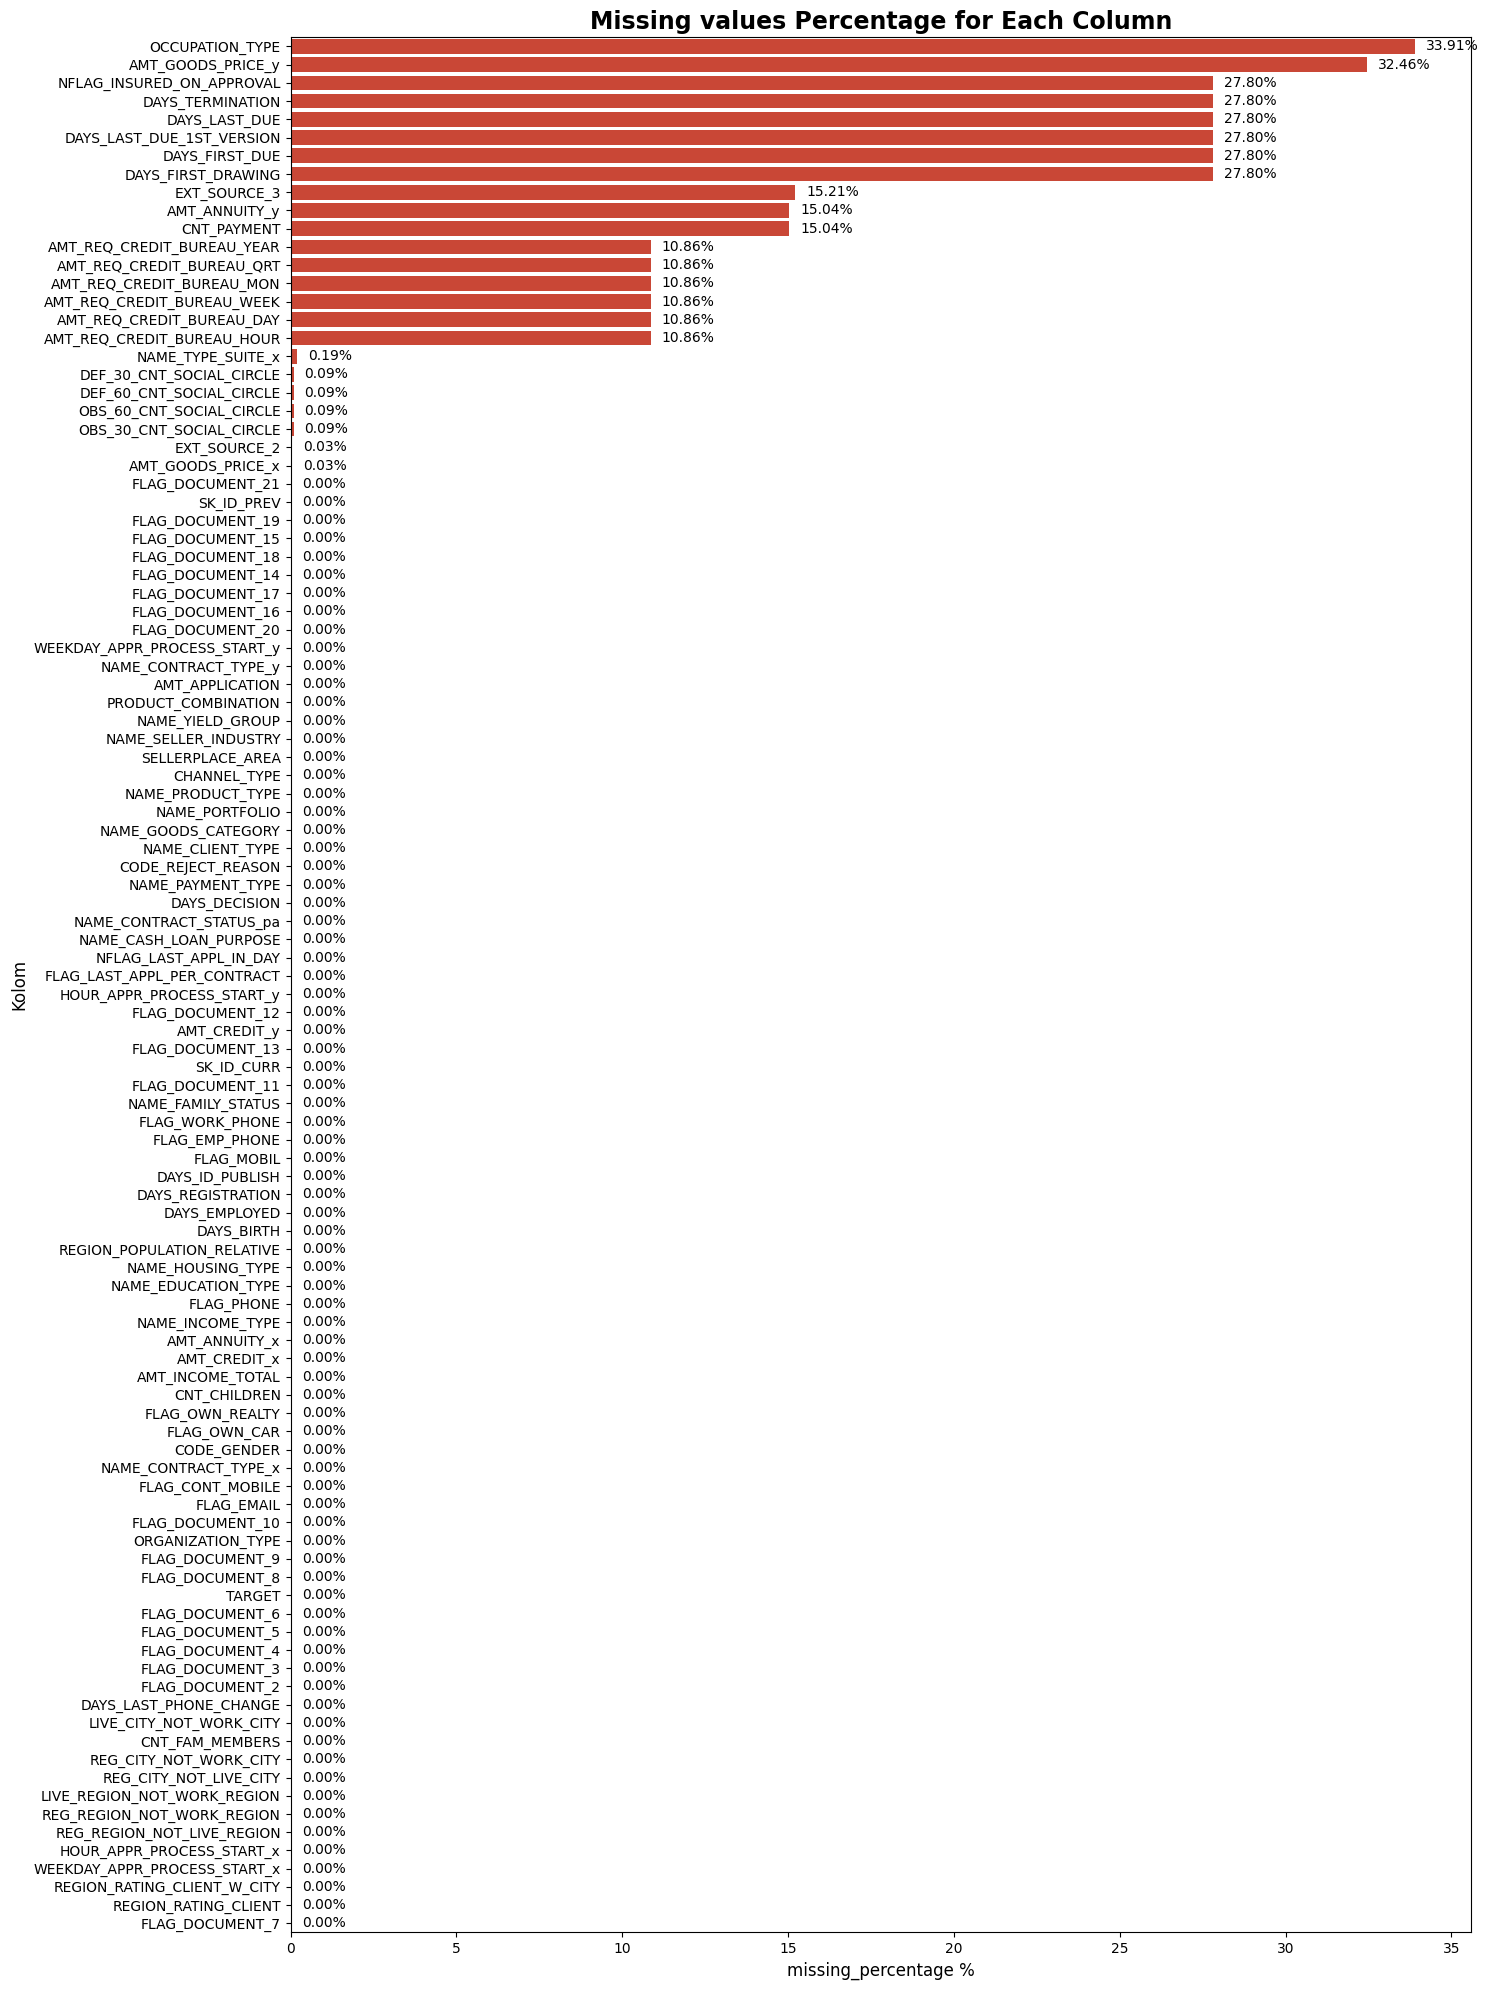

None

test data: 
(1054, 103)


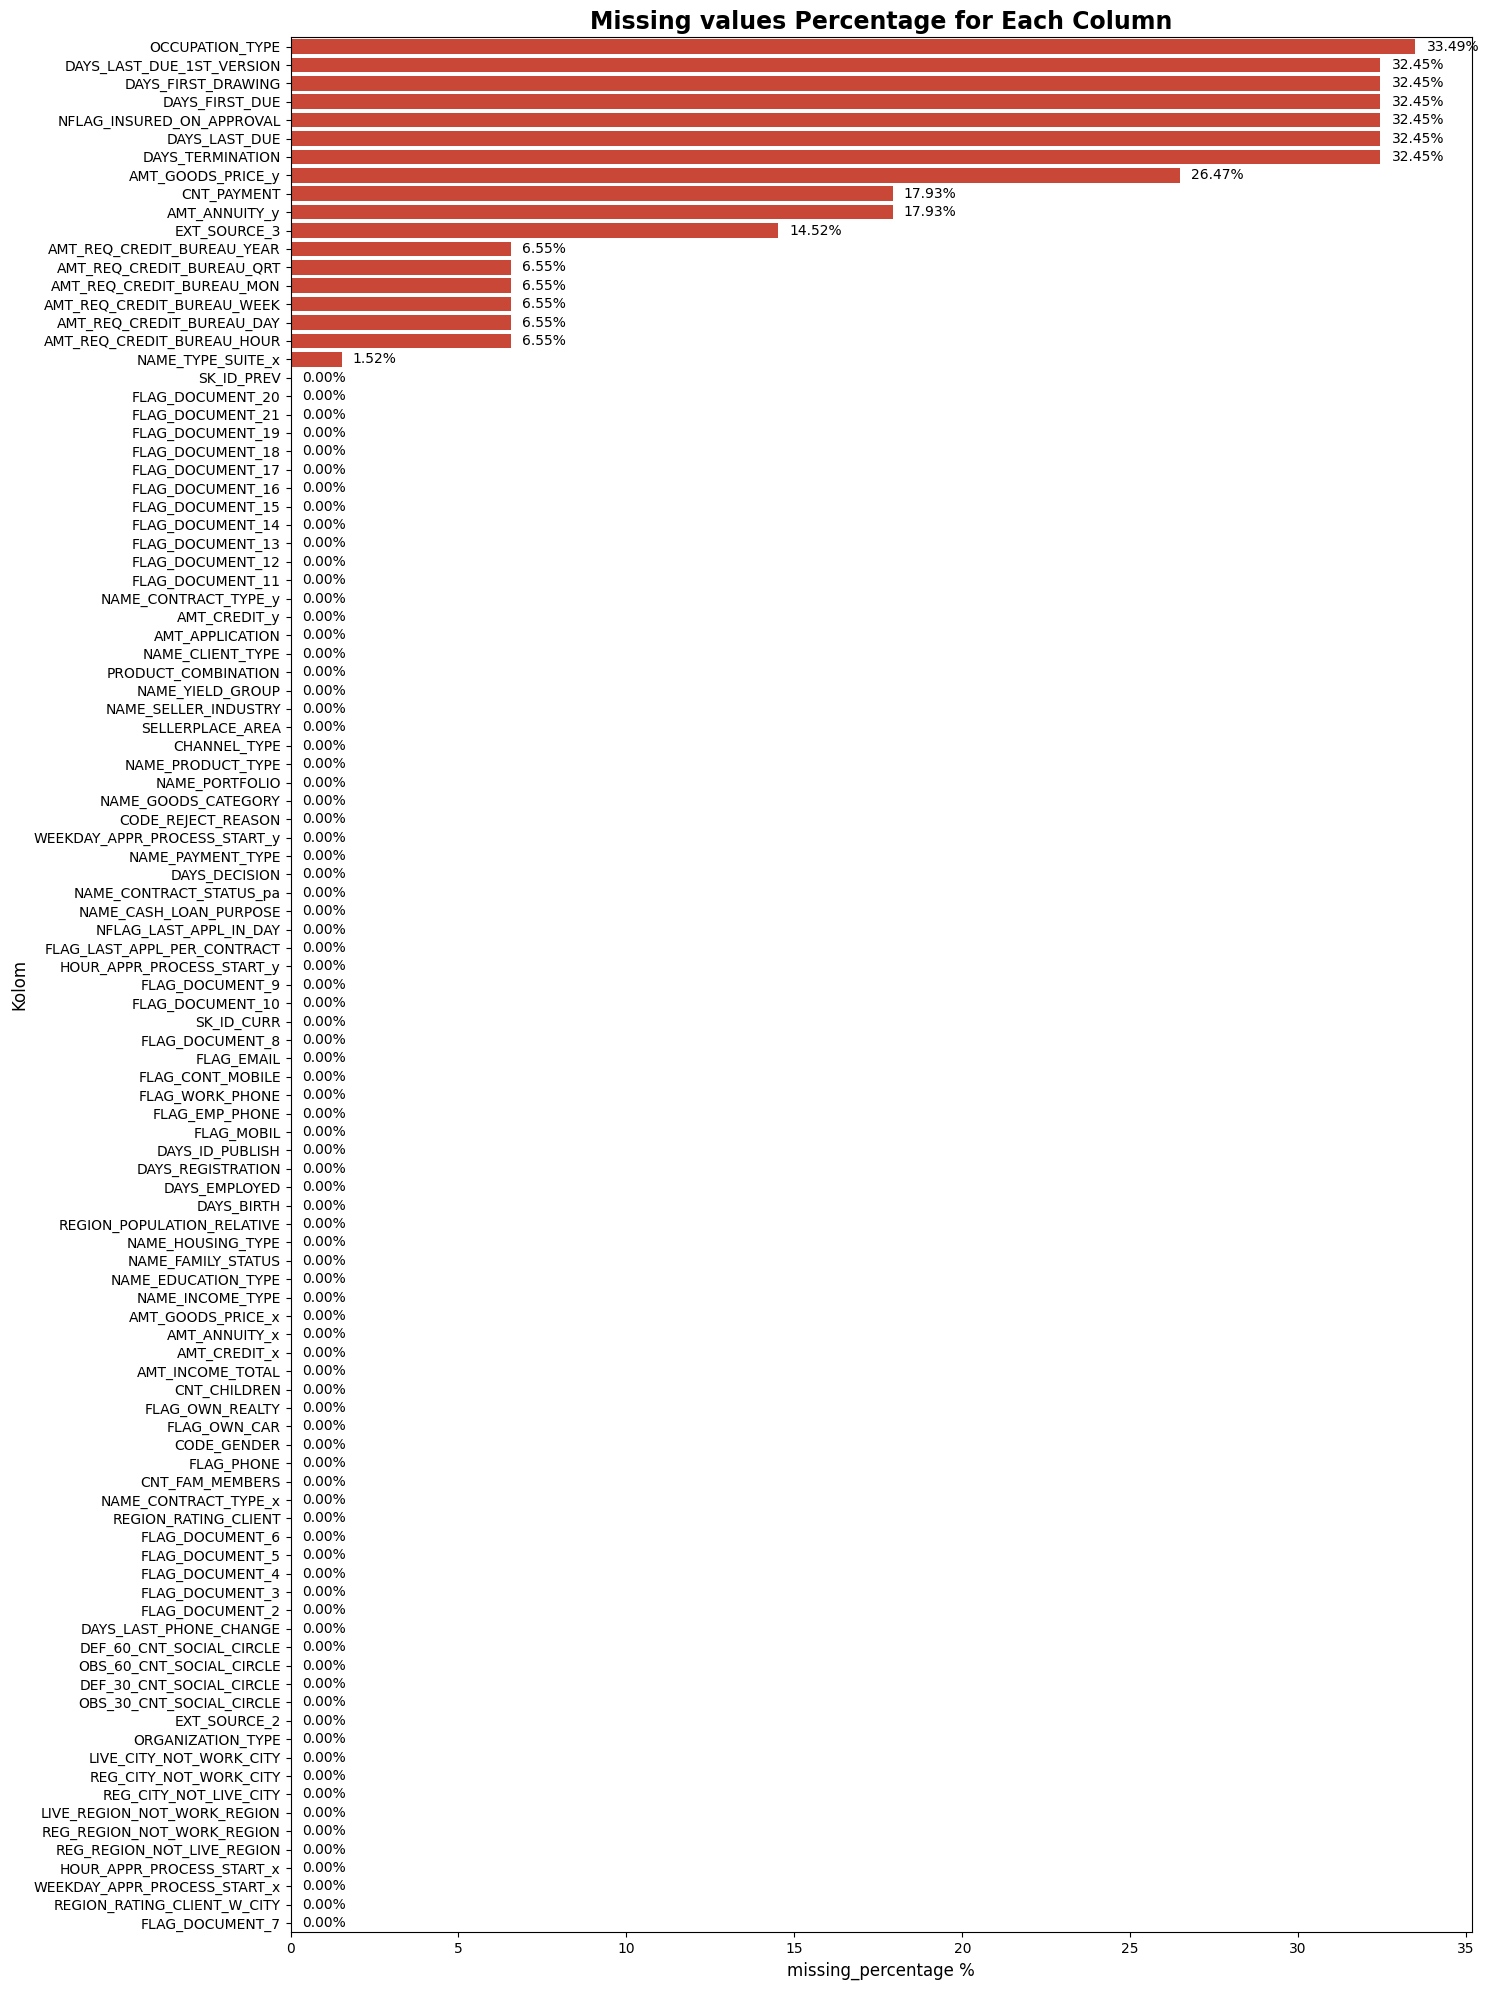

None

In [58]:
train_full = dropna(train_full)
print(f'train data: \n{train_full.shape}')
display(plot_missing_percentage(train_full))

test_full = dropna(test_full)
print(f'test data: \n{test_full.shape}')
display(plot_missing_percentage(test_full))

## EDA

In [64]:
age = train_full[['DAYS_BIRTH']].copy()

age['AGE'] = round(abs(age['DAYS_BIRTH'] / 365.25)).astype(int)
age

,DAYS_BIRTH,AGE
0,-25036,69
1,-25036,69
2,-13724,38
3,-16599,45
4,-11303,31
...,...,...
5740,-22131,61
5741,-19074,52
5742,-22087,60
5743,-15279,42


In [ ]:
time_feat = ['DAYS_DECISION']

In [60]:
train_full

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,NAME_TYPE_SUITE_x,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START_x,HOUR_APPR_PROCESS_START_x,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_PREV,NAME_CONTRACT_TYPE_y,AMT_ANNUITY_y,AMT_APPLICATION,AMT_CREDIT_y,AMT_GOODS_PRICE_y,WEEKDAY_APPR_PROCESS_START_y,HOUR_APPR_PROCESS_START_y,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS_pa,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,245391,0,Cash loans,F,N,Y,0,99000.0,239850.0,23719.5,225000.0,Family,Pensioner,Lower secondary,Widow,House / apartment,0.024610,-25036,365243,-16240.0,-3973,1,0,0,1,0,0,NaN,1.0,2,2,TUESDAY,12,0,0,0,0,0,0,XNA,0.646878,0.709189,0.0,0.0,0.0,0.0,-347.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,2038648,Consumer loans,6911.955,65826.0,65497.5,65826.0,FRIDAY,12,Y,1,XAP,Approved,-347,Cash through the bank,XAP,Refreshed,Consumer Electronics,POS,XNA,Country-wide,1500,Consumer electronics,12.0,middle,POS household with interest,365243.0,-316.0,14.0,365243.0,365243.0,0.0
1,245391,0,Cash loans,F,N,Y,0,99000.0,239850.0,23719.5,225000.0,Family,Pensioner,Lower secondary,Widow,House / apartment,0.024610,-25036,365243,-16240.0,-3973,1,0,0,1,0,0,NaN,1.0,2,2,TUESDAY,12,0,0,0,0,0,0,XNA,0.646878,0.709189,0.0,0.0,0.0,0.0,-347.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,2038648,Consumer loans,6911.955,65826.0,65497.5,65826.0,FRIDAY,12,Y,1,XAP,Approved,-347,Cash through the bank,XAP,Refreshed,Consumer Electronics,POS,XNA,Country-wide,1500,Consumer electronics,12.0,middle,POS household with interest,365243.0,-316.0,14.0,365243.0,365243.0,0.0
2,139143,0,Cash loans,M,N,Y,0,270000.0,940500.0,27499.5,940500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.019689,-13724,-3371,-2402.0,-4511,1,1,1,1,1,0,Core staff,2.0,2,2,FRIDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.645158,0.438281,0.0,0.0,0.0,0.0,-1090.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0,1800605,Consumer loans,4637.070,26995.5,23607.0,26995.5,SATURDAY,9,Y,1,XAP,Approved,-1252,Cash through the bank,XAP,Repeater,Computers,POS,XNA,Country-wide,3500,Consumer electronics,6.0,middle,POS household with interest,365243.0,-1221.0,-1071.0,-1101.0,-1097.0,0.0
3,387410,0,Cash loans,F,N,Y,0,225000.0,1001884.5,51156.0,895500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.024610,-16599,-3100,-5053.0,-105,1,1,0,1,0,0,Sales staff,2.0,2,2,THURSDAY,17,0,0,0,0,0,0,

<Axes: xlabel='TARGET', ylabel='count'>

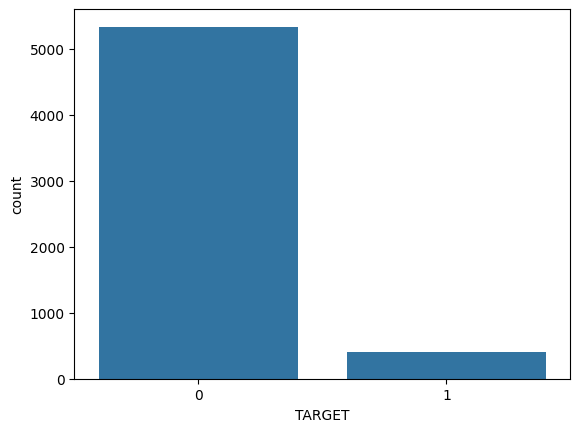

In [59]:
sns.countplot(x='TARGET', data=train_full)

-------

In [ ]:
# df2clean = [train_sample, test_sample, bureau_sample, bb_sample, ccb_sample, ip_sample, pb_sample, pa_sample]

# for i, df in enumerate(df2clean):
#     df2clean[i] = dropna(df)

# train_sample, test_sample, bureau_sample, bb_sample, ccb_sample, ip_sample, pb_sample, pa_sample = df2clean


In [ ]:
# # Merge data
# train_instllmnt = pd.merge(train_sample, ip_sample, on='SK_ID_CURR', how='left', suffixes=('_tr', '_ip'))
# train_cb = pd.merge(train_instllmnt, ccb_sample, on='SK_ID_CURR', how='left', suffixes=('_tr', '_ccb'))
# train_pb = pd.merge(train_cb, pb_sample, on='SK_ID_CURR', how='left', suffixes=('_tr', '_pb'))
# bureau_merge = pd.merge(bureau_sample, bb_sample, on='SK_ID_BUREAU', how='left')
# train_semi = pd.merge(train_sample, bureau_merge, on='SK_ID_CURR', how='left', suffixes=('_tr', '_bu'))

# # Train data
# train_full = pd.merge(train_semi, pa_sample, on='SK_ID_CURR', how='left', suffixes=('_tr', '_pa'))

# # Test data
# test_full = pd.merge(test_sample, pa_sample, on='SK_ID_CURR', how='left')

In [ ]:
# # Merge data
# pa_instllmnt = pd.merge(pa_sample, ip_sample, on='SK_ID_PREV', how='left', suffixes=('_pa', '_ip'))

# pa_cb = pd.merge(pa_instllmnt, ccb_sample, on='SK_ID_PREV', how='left', suffixes=('_pa', '_ccb'))

# pa_full = pd.merge(pa_cb, pb_sample, on='SK_ID_CURR', how='left', suffixes=('_pa', '_pb'))

# bureau_merge = pd.merge(bureau_sample, bb_sample, on='SK_ID_BUREAU', how='left')


# # Train data
# tb = pd.merge(train_sample, bureau_merge, on='SK_ID_CURR', how='left', suffixes=('_tr', '_bu'))
# train_full = pd.merge(tb, pa_full, on='SK_ID_CURR', how='left', suffixes=('_tr', '_pa'))

# # Test data
# tb = pd.merge(test_sample, bureau_merge, on='SK_ID_CURR', how='left', suffixes=('_tr', '_bu'))
# test_full = pd.merge(tb, pa_full, on='SK_ID_CURR', how='left')

In [ ]:
# # Select necessary columns
# ip_sample = ip_sample.drop(columns='SK_ID_PREV')
# ccb_sample = ccb_sample.drop(columns='SK_ID_PREV')
# pb_sample = pb_sample.drop(columns='SK_ID_CURR')
# bb_sample = bb_sample.drop(columns='SK_ID_BUREAU')

# # Merge data
# pa_instllmnt = pd.merge(pa_sample, ip_sample, on='SK_ID_PREV', how='left', suffixes=('_pa', '_ip'))
# pa_cb = pd.merge(pa_instllmnt, ccb_sample, on='SK_ID_PREV', how='left', suffixes=('_pa', '_ccb'))
# pa_full = pd.merge(pa_cb, pb_sample, on='SK_ID_CURR', how='left', suffixes=('_pa', '_pb'))
# bureau_merge = pd.merge(bureau_sample, bb_sample, on='SK_ID_BUREAU', how='left')

# # Train data
# tb = pd.merge(train_sample, bureau_merge, on='SK_ID_CURR', how='left', suffixes=('_tr', '_bu'))
# train_full = pd.merge(tb, pa_full, on='SK_ID_CURR', how='left', suffixes=('_tr', '_pa'))

# # Test data
# tb = pd.merge(test_sample, bureau_merge, on='SK_ID_CURR', how='left', suffixes=('_tr', '_bu'))
# test_full = pd.merge(tb, pa_full, on='SK_ID_CURR', how='left')

In [ ]:
# # Select the columns you want from each dataframe excluding the identifier column
# ip_sample_selected = ip_sample.drop('SK_ID_PREV', axis=1)
# ccb_sample_selected = ccb_sample.drop('SK_ID_PREV', axis=1)
# pb_sample_selected = pb_sample.drop('SK_ID_CURR', axis=1)
# bureau_merge_selected = bureau_merge.drop('SK_ID_CURR', axis=1)

# # Merge the dataframes
# pa_instllmnt = pd.merge(pa_sample, ip_sample_selected, left_on='SK_ID_PREV', right_index=True, how='left')
# pa_cb = pd.merge(pa_instllmnt, ccb_sample_selected, left_on='SK_ID_PREV', right_index=True, how='left')
# pa_full = pd.merge(pa_cb, pb_sample_selected, left_on='SK_ID_CURR', right_index=True, how='left')

# # Select the columns you want from pa_full excluding the identifier column
# pa_full_selected = pa_full.drop('SK_ID_CURR', axis=1)

# # Merge with train_sample and test_sample
# train_semi = pd.merge(train_sample, pa_full_selected, left_on='SK_ID_CURR', right_index=True, how='left')
# train_full = pd.merge(train_semi, bureau_merge_selected, left_on='SK_ID_CURR', right_index=True, how='left')


# test_semi = pd.merge(test_sample, pa_full_selected, left_on='SK_ID_CURR', right_index=True, how='left')
# test_full = pd.merge(test_semi, bureau_merge_selected, left_on='SK_ID_CURR', right_index=True, how='left')